## Logerror Regression Project With Clustering Methods: Zillow Data Set

### Scenario
    Utilizing the 2017 Zillow data set, I set out to build a model that would predict the logerror of single family homes, examining the correlation between the data points and our target variable (logerror). I will identify critical features that can be used in a regression model to predict logerror as well as incorporating feature engineering utilizing clustering methods.

### Project Planning
#### Goal:
The goal for this project is to create a model that will accurately predict a home's logerror determined by the county's Appraisal District. To do so, I will have to identify which of the various features are drivers to this end, and implement them into a machine learning regression model.

#### Initial Hypotheses:

#### There is a relationship between county location and logerror.


#### There is a correlation between number of luxury home items such as pool, garage, number of rooms and square footage.

### Project Planning Initial Thoughts:
#### My initial thoughts were that there would be a direct relationship to the location of the property and its logerror.
    Additionally, I believe there to be a correlation, not just to the number of bedrooms and bathrooms, but also to a ratio of square footage per number of rooms and what I called luxury items such as a pool, garage, air conditioning etc.


### Key Findings
    -Exploration Takeaways
After removing data set outliers, especially those homes with more than 6 bedrooms, 7 bathrooms, over a value of $3,000,000, and with a square footage of more than 10,000 sqft.

### Mean logerror = 0.01816 
### RMSE baseline = .175 
### Best model = Tweedie Regressor with RMSE .175

In [1]:
# regular imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import env
import seaborn as sns
import wrangle as wr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.cluster import KMeans
import viz


# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split

#evaluate
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression 
from statsmodels.formula.api import ols
import sklearn.preprocessing

#feature engineering
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# from our acquire.py:
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
sql_query = '''
        SELECT prop.*,
        predictions_2017.logerror,
        predictions_2017.transactiondate,
        air.airconditioningdesc,
        arch.architecturalstyledesc,
        build.buildingclassdesc,
        heat.heatingorsystemdesc,
        land.propertylandusedesc,
        story.storydesc,
        type.typeconstructiondesc
        FROM properties_2017 prop
        JOIN (
            SELECT parcelid, MAX(transactiondate) AS max_transactiondate
            FROM predictions_2017
            GROUP BY parcelid
            ) pred USING(parcelid)
        JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                          AND pred.max_transactiondate = predictions_2017.transactiondate
        LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
        LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
        LEFT JOIN storytype story USING(storytypeid)
        LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
        WHERE propertylandusedesc = "Single Family Residential"
            AND transactiondate <= '2017-12-31'
            AND prop.longitude IS NOT NULL
            AND prop.latitude IS NOT NULL
        '''
    
def get_zillow_data():
    df = pd.read_sql(sql_query, get_connection('zillow'))
    df = df.drop(columns='id')
    return df

In [3]:
df = get_zillow_data()

In [4]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,14297519,NaN,NaN,NaN,3.50,4.00,None,NaN,3.50,NaN,...,"60,590,630,072,012.00",0.03,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,17052889,NaN,NaN,NaN,1.00,2.00,None,NaN,1.00,NaN,...,"61,110,010,023,006.00",0.06,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,14186244,NaN,NaN,NaN,2.00,3.00,None,NaN,2.00,NaN,...,"60,590,218,022,012.00",0.01,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,12177905,NaN,NaN,NaN,3.00,4.00,None,8.00,3.00,NaN,...,"60,373,001,001,006.00",-0.10,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,12095076,1.00,NaN,NaN,3.00,4.00,None,9.00,3.00,NaN,...,"60,374,608,001,014.00",-0.00,2017-01-01,Central,None,None,Central,Single Family Residential,None,None


In [5]:
sns.set_theme()

(-1.0, 1.0)

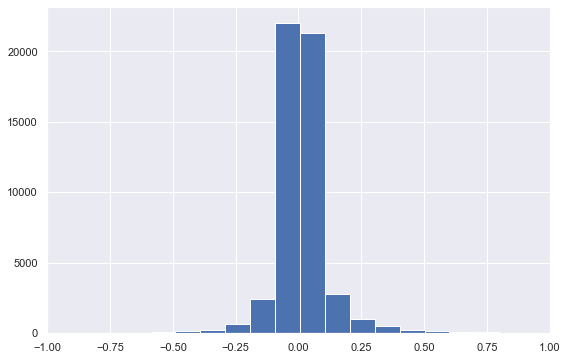

In [6]:
#Distribution of target variable
plt.hist(x=df['logerror'], bins=100)
plt.xlim(-1, 1)

In [7]:
(df.isnull().sum()/df.shape[0]*100)[:] # Percentage of nulls in each column

parcelid                                   0.00
airconditioningtypeid                     73.98
architecturalstyletypeid                  99.87
basementsqft                              99.91
bathroomcnt                                0.00
                                   ...         
buildingclassdesc                        100.00
heatingorsystemdesc                       35.30
propertylandusedesc                        0.00
storydesc                                 99.91
typeconstructiondesc                      99.85
Length: 67, dtype: float64

### Large portion of the data set pulled had a ton of null values

In [8]:
#handle missing values with more than 13% nulls
def handle_missing_values(df, prop_required_columns =0.87, prop_required_row=0.87):
    threshold = int(round(prop_required_columns * len(df.index), 0))
    #axis 1 : drop columns that have missing values
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns),0))
    #axis 0 : drop rows that have missing values
    df = df.dropna(axis=0, thresh=threshold)
    return df

In [9]:
#remove columns
def remove_columns(df, cols_to_remove):
    df = df.drop(columns = cols_to_remove)
    return df

In [10]:
# combining everything in a cleaning function:
def data_prep(df, cols_to_remove=[], prop_required_column=0.87, prop_required_row=0.87):
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [11]:
df = data_prep(df, cols_to_remove = ['airconditioningtypeid',
 'architecturalstyletypeid',
 'buildingclasstypeid',
 'buildingqualitytypeid',
 'calculatedbathnbr',
 'decktypeid',
 'finishedfloor1squarefeet',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'garagetotalsqft',
 'hashottuborspa',
 'heatingorsystemtypeid',
 'poolsizesum',
 'pooltypeid10',
 'pooltypeid2',
 'pooltypeid7',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'propertyzoningdesc',
 'rawcensustractandblock',
 'roomcnt',
 'storytypeid',
 'threequarterbathnbr',
 'typeconstructiontypeid',
 'unitcnt',
 'yardbuildingsqft17',
 'yardbuildingsqft26',
 'numberofstories',
 'fireplaceflag',
 'assessmentyear',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'censustractandblock',
 'architecturalstyledesc',
 'buildingclassdesc',
 'propertylandusedesc',
 'regionidneighborhood',                                   
 'storydesc',
 'typeconstructiondesc'], prop_required_column=0.15, prop_required_row=0.15)

In [12]:
df.columns.values.tolist()

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fips',
 'fullbathcnt',
 'garagecarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'regionidcity',
 'regionidcounty',
 'regionidzip',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror',
 'transactiondate',
 'airconditioningdesc',
 'heatingorsystemdesc']

### Utilize clean_and_prep function in the wrangle.py file to rename columns for ease of use, remove homes with 0 bedrooms, filled specified null/nonetype to 0, implement feature engineering, manually impute nulls ofto the correct data types

In [13]:
df = wr.clean_and_prep(df)

In [15]:
#verify no nulls
df.isna().sum()

parcelid                               0
bathrooms                              0
bedrooms                               0
sqft                                   0
fips                                   0
fullbathcnt                            0
garagecarcnt                           0
latitude                               0
longitude                              0
lotsizesquarefeet                      0
poolcnt                                0
regionidcity                           0
regionidcounty                         0
regionidzip                            0
yearbuilt                              0
structuretaxvaluedollarcnt             0
home_value                             0
landtaxvaluedollarcnt                  0
taxamount                              0
logerror                               0
transactiondate                        0
airconditioningdesc                    0
heatingorsystemdesc                    0
home_value_structure_tax_difference    0
hvs_pct         

### Utilize optimize_types function in the wrangle.py file to convert specified columns to the correct data types

In [16]:
df = wr.optimize_types(df)

### Additional feature engineering

In [17]:
# feature engineering luxuryscore will be counts for pool, garage, ac, number of bathrooms and bedrooms
df['luxury_score'] = (df['poolcnt']+df['garagecarcnt']+df['bedrooms']+df['bathrooms']+df['airconditioning_encoded'])

#feature engineering luxury score/age*sqft
df['luxury_sqft_per_age']= (df['luxury_score']*df['sqft']/df['age'])
df['luxury_sqft_per_age']=df['luxury_sqft_per_age'].astype(int)
#feature engineering
df['quarter'] = pd.PeriodIndex(df.transactiondate, freq='Q')
df['quarter']=df['quarter'].astype(str)

#dummy encode quarter
quarter_df = pd.get_dummies(df.quarter)
df = pd.concat([df, quarter_df],axis=1)

In [18]:
def get_counties():
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    df_dummies = df_dummies.drop(columns = ['regionidcounty'])
    return df_dummies

In [19]:
df = get_counties()

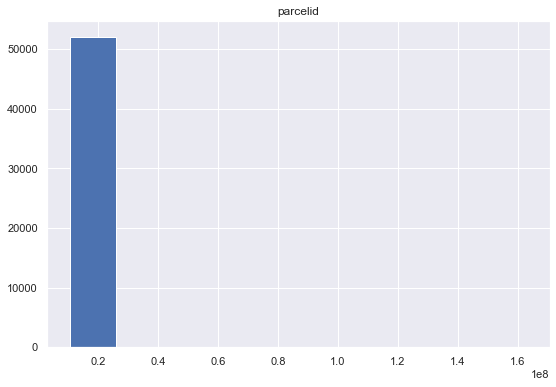

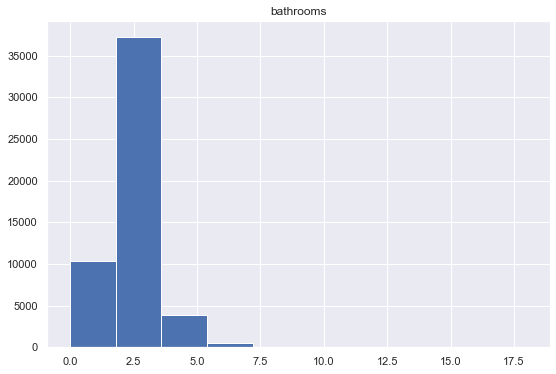

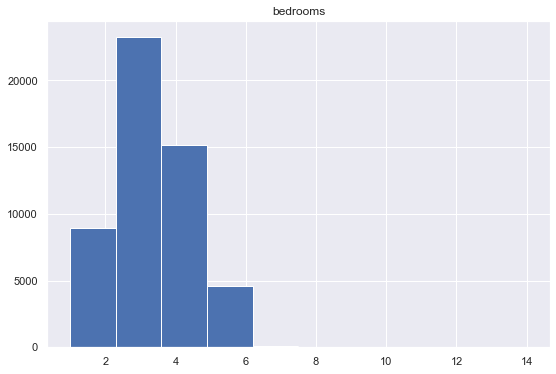

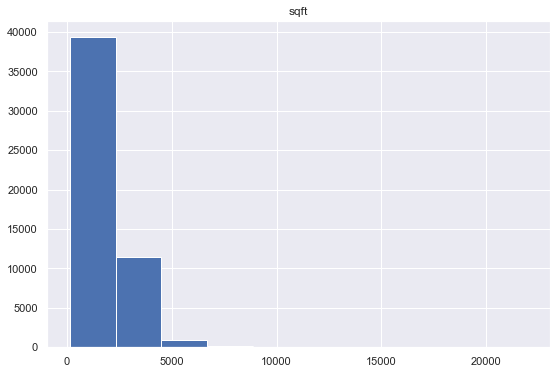

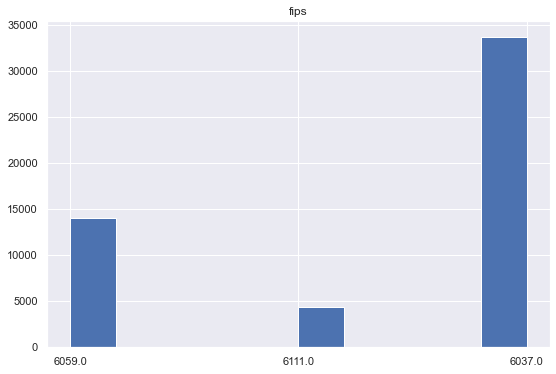

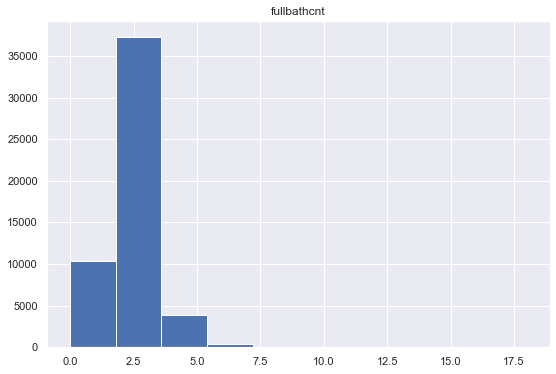

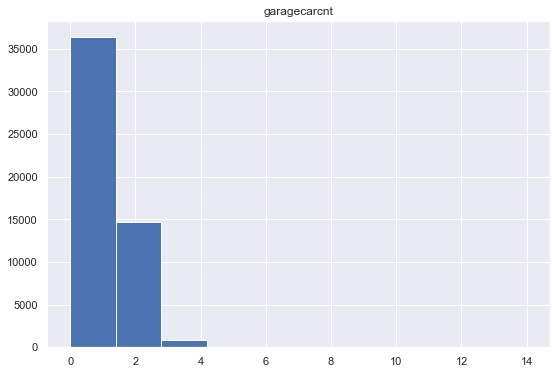

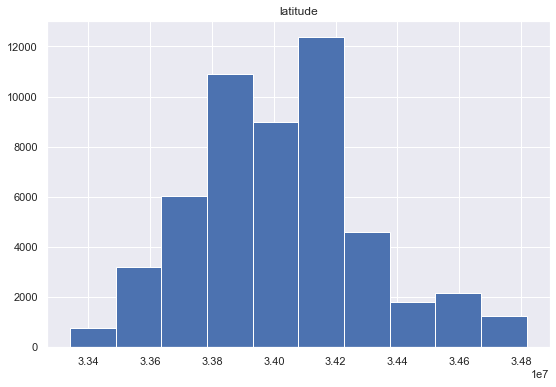

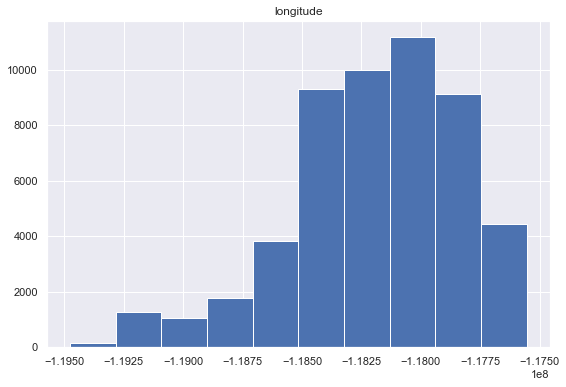

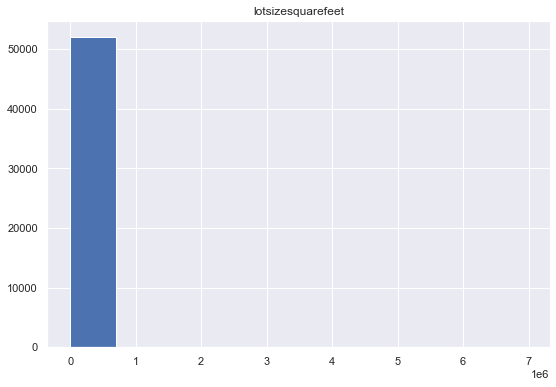

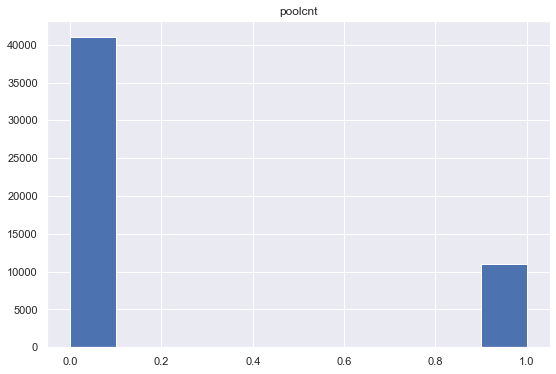

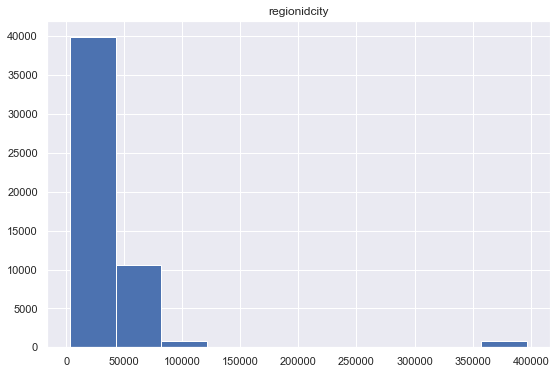

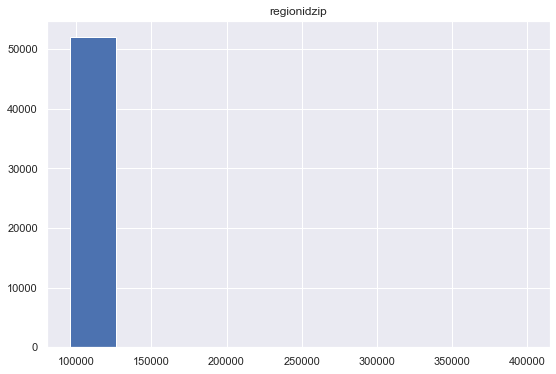

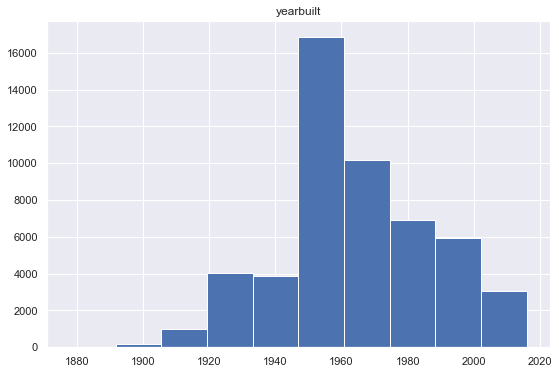

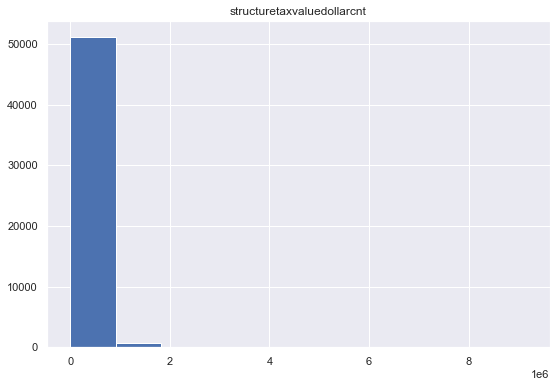

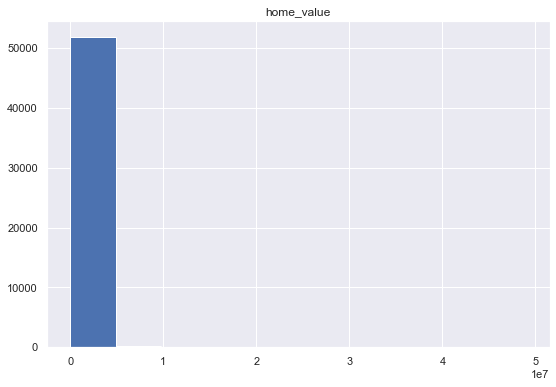

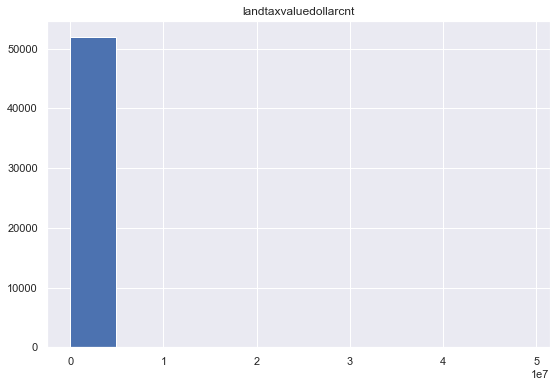

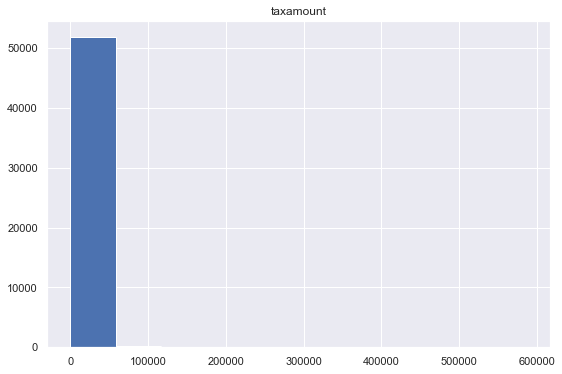

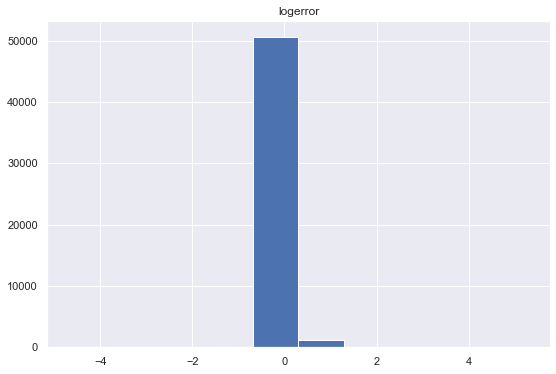

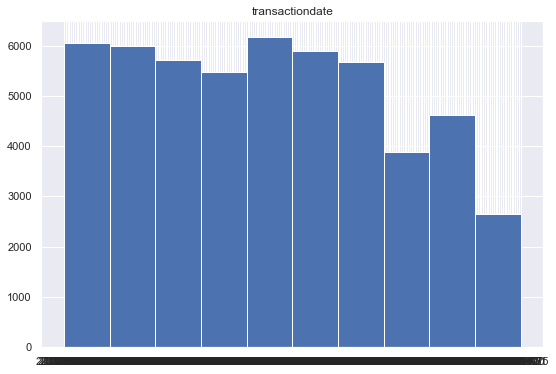

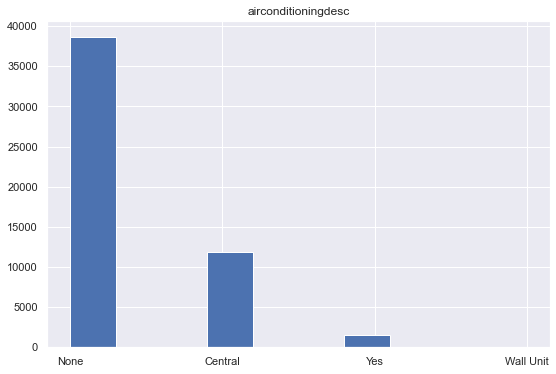

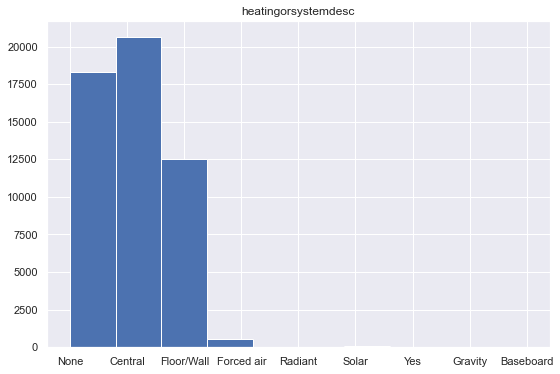

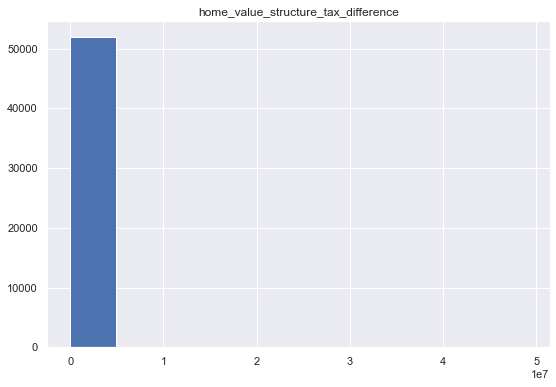

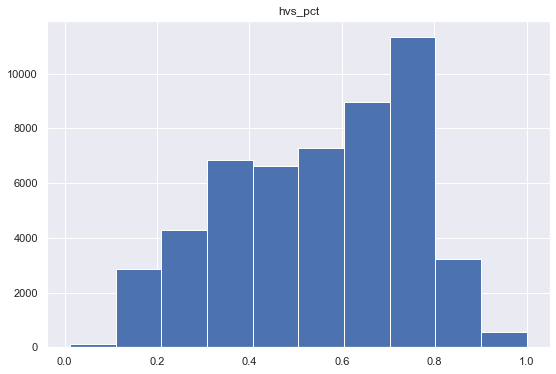

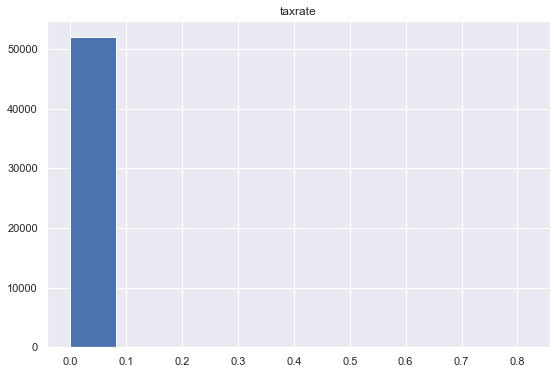

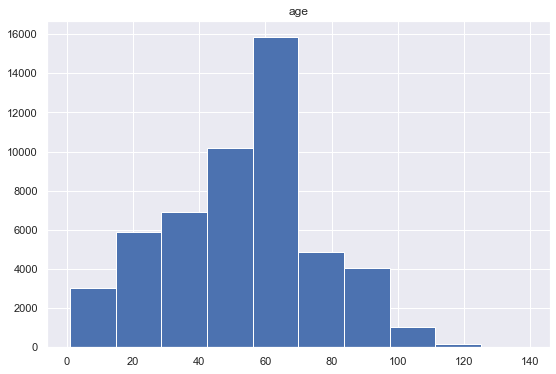

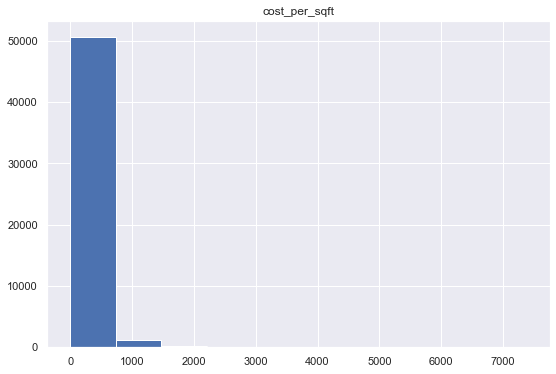

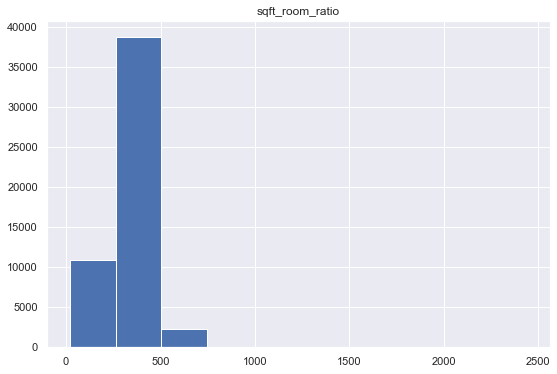

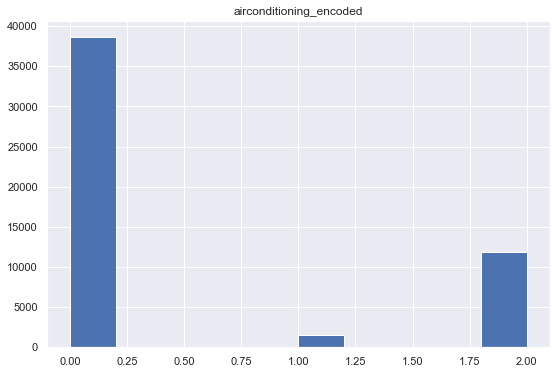

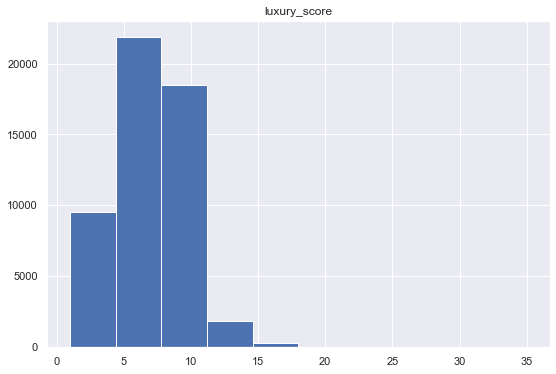

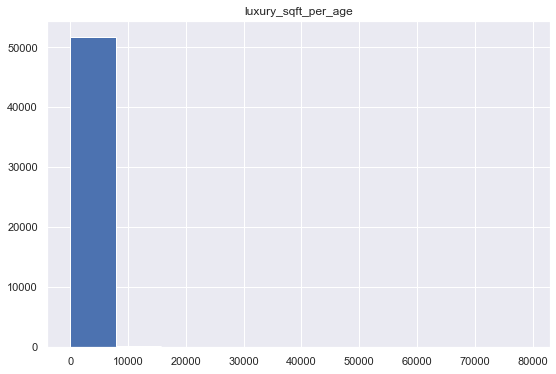

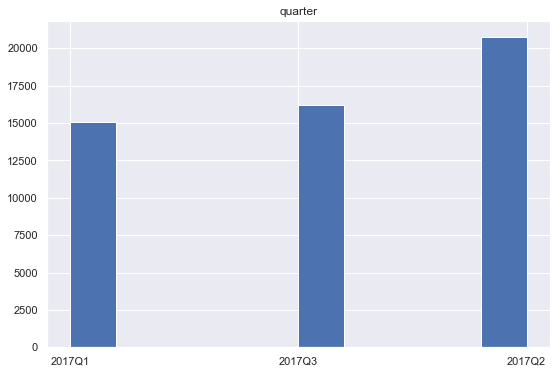

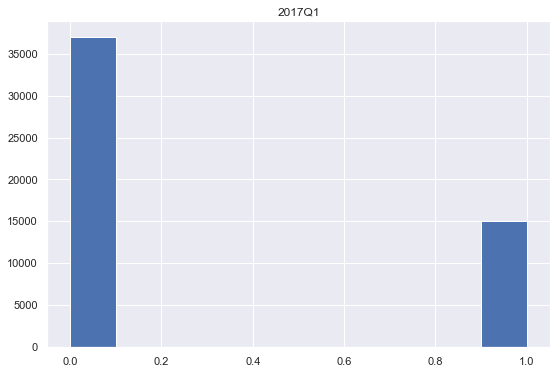

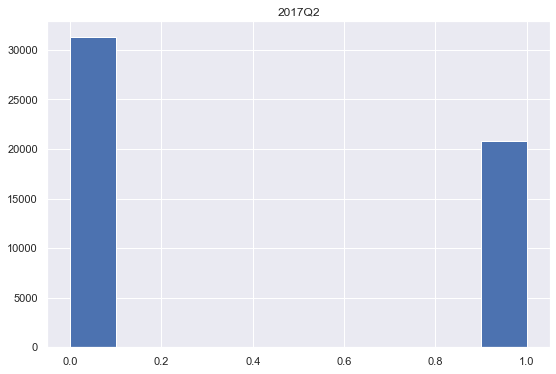

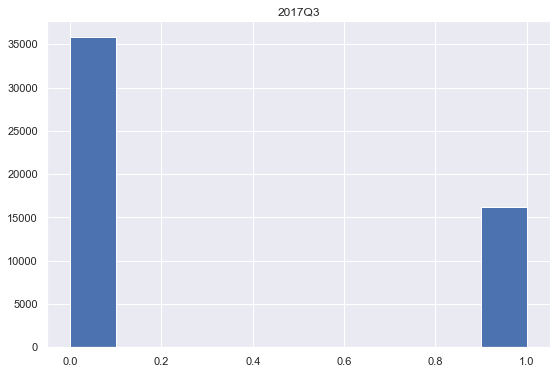

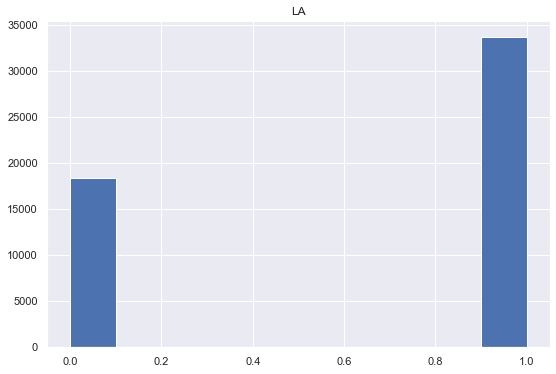

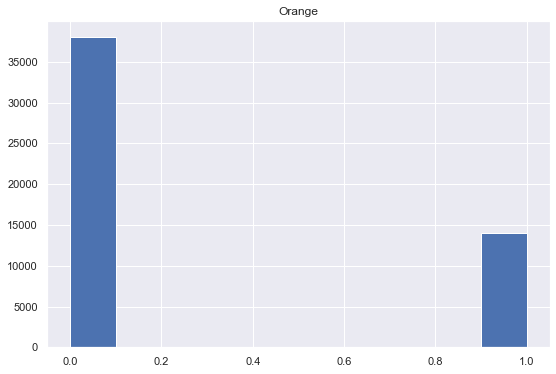

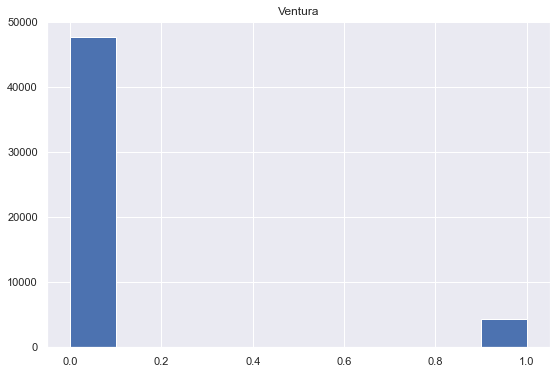

In [20]:
for col in df.columns:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

### After observing the outliers, I decided to manually remove them
    - bathrooms less than 7 bedrooms less than 6, value less than 3M, sqft less than 10000

In [21]:
df = wr.handle_outliers(df)

### Exploration
    - split data
    - visual and graphical analysis
    - hypothesis testing on questions raised
    - key findings/summary/
    - prepped for clustering with scaled data

In [22]:
#use split function in wrangle.py
train, X_train, X_validate, X_test, y_train, y_validate, y_test = wr.split(df, target_var='logerror')

In [23]:
#binned logerror for easy visuals
train['logerror_bins'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])

In [24]:
train.logerror_bins.value_counts()

(-0.05, 0.05]    18769
(0.05, 0.2]       4558
(-0.2, -0.05]     3488
(0.2, 4.0]        1317
(-5.0, -0.2]       660
Name: logerror_bins, dtype: int64

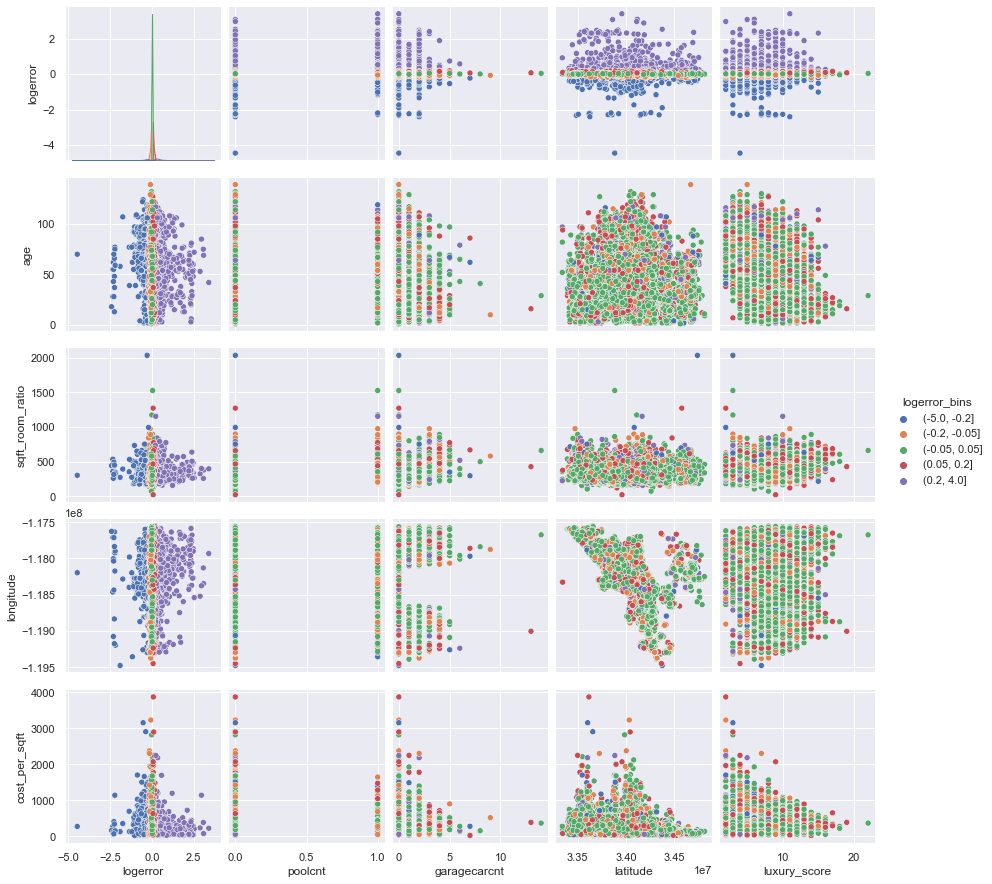

In [25]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'poolcnt', 'garagecarcnt', 'latitude', 
                       'luxury_score'],
             y_vars = ['logerror', 'age', 'sqft_room_ratio', 'longitude', 'cost_per_sqft'])

1. appears that larger longitude(further west) correllates to lower error
2. cost per sq ft is lower there is correlation to higher error
3. lower sq ft room ratio points to higher error
4. age is interesting, looks like there are periods of years that have higher error
5. pockets of higher cost per sqft at diff longitudes

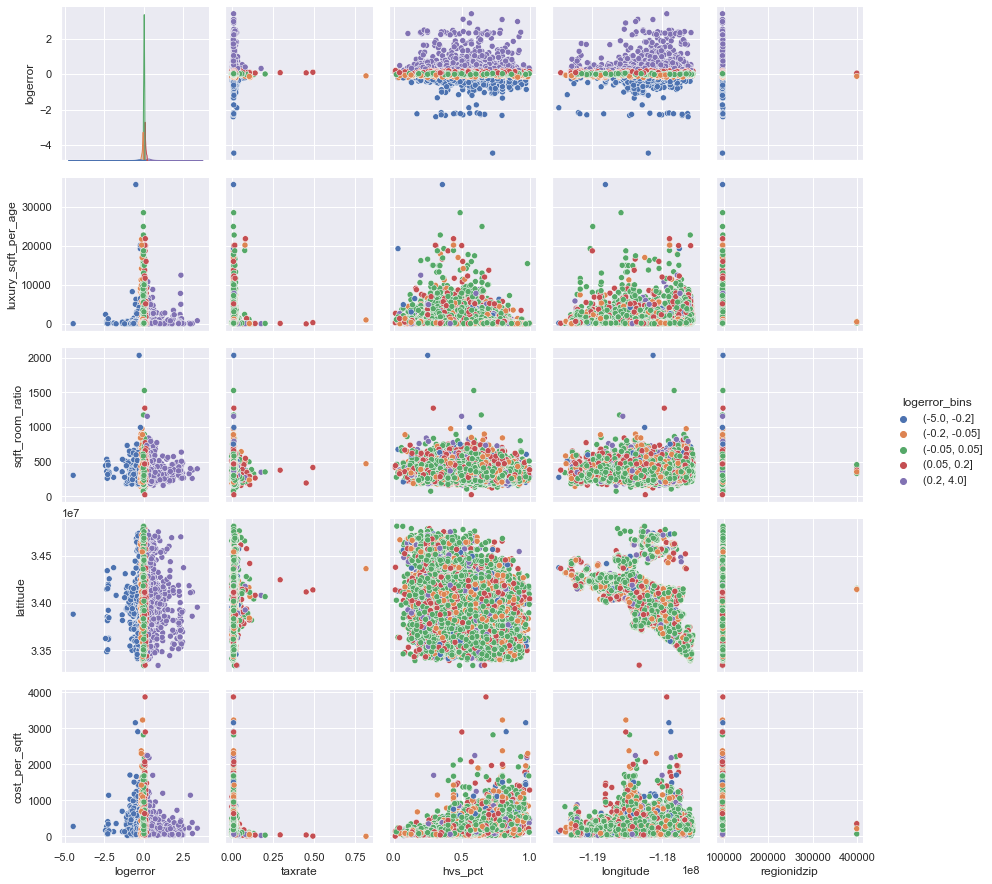

In [26]:
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['logerror', 'taxrate', 'hvs_pct', 'longitude', 
                       'regionidzip'],
             y_vars = ['logerror', 'luxury_sqft_per_age', 'sqft_room_ratio', 'latitude', 'cost_per_sqft'])

    1. log error and tax rate are correllated, lower has greater error
    2. log error and hvs pct have an interesting chart
    3. lower log error towards the southern and northern latitudes
    4. plot of lat long is awesome, la area map!
    5. luxurysqft/age related to logerror

### Now I have a basis for my stats tests which I performed ANOVA, and correlation tests

### Question

Is log error significantly different for properties based on time of year transaction occurred?

### Ho: Log error will be the same across all quarters observed.

### Ha: Log error will vary based quarter observed.

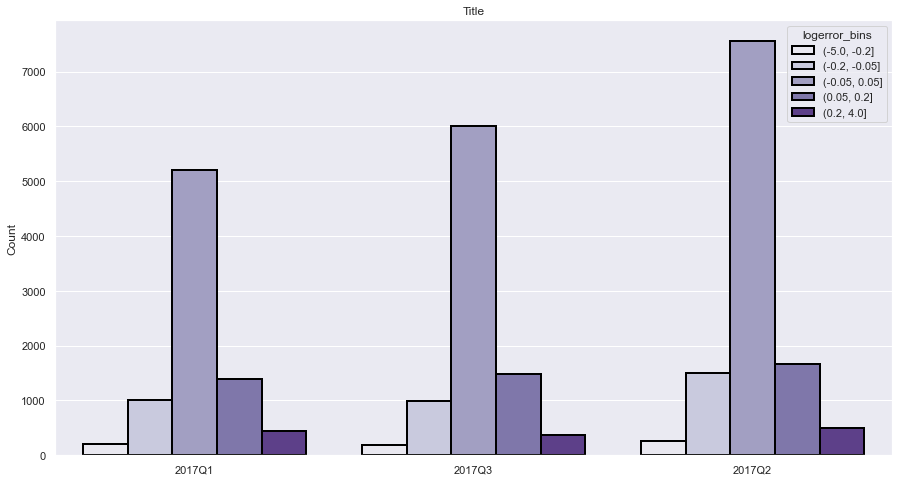

In [27]:
plt.figure(figsize=(15,8))
sns.countplot(x = 'quarter', hue='logerror_bins', data=train, palette='Purples', ec='black', linewidth=2)

plt.title('Title')
plt.xlabel('')
plt.ylabel('Count')

plt.show()

In [ ]:
#looks like the distribution of log error is the same for all quarters examined

In [28]:
#Set the value of alpha for statistical tests
alpha = 0.05

In [29]:
#Conduct an ANOVA test between the counties
f_quarters, p_quarters = stats.f_oneway(df[df['quarter'] == '2017Q1'].logerror,
                                    df[df['quarter'] == '2017Q2'].logerror,
                                    df[df['quarter'] == '2017Q3'].logerror)

f_quarters, p_quarters

(8.541547207327264, 0.00019546514837721595)

In [30]:
#Compare my p value to alpha
if p_quarters < alpha:
    print('We reject the null hypothesis.')
else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis.


## Key Takeaways/Summary of stats tests

Hypothesis Testing
Tested Hypotheses

### 1. Ho: Log error will be the same across all quarters observed.
    Ha: Log error will vary based quarter observed.
    -We reject the null hypothesis.

### 2. Ho: Log error will be the same across all three counties.
    Ha: Log error will vary based on county.
    -We reject the null hypothesis.

### 3. Ho: There is no correlation between tax rate and log error.
    Ha: There is a relationship between tax rate and log error.
    -We fail to reject the null hypothesis. There is a relationship between tax rate and log error

### 4. Ho: There is no correlation between longitude and log error.
    Ha: There is a relationship between longitude and log error.
    -We reject the null hypothesis. Strong relationship between longitude and logerror

### 5. Ho: There is no correlation between cost per sqft and log error.
    Ha: There is a relationship between cost per sqft and log error.
    -We reject the null hypothesis. Strong relationship between cost_per_sqft and logerror

### 6. Ho: There is no correlation between luxury_sqft_per_age and log error.
    Ha: There is a relationship between luxury_sqft_per_age and log error.
   -We reject the null hypothesis. Strong relationship between luxury_sqft_per_age and log error.

#### All of the tests can be found in the zillow_logerror_regression_project notebook

### Scale
I will scale all of our features using MinMaxScaler

In [31]:
X_train.shape,X_validate.shape,X_test.shape

((28792, 37), (12340, 37), (10284, 37))

In [32]:
X_train = X_train.drop(columns=['parcelid', 'fips', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'transactiondate',
 'airconditioningdesc', 'heatingorsystemdesc', 'quarter'])
X_validate = X_validate.drop(columns=['parcelid', 'fips', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'transactiondate',
 'airconditioningdesc', 'heatingorsystemdesc', 'quarter'])
X_test = X_test.drop(columns=['parcelid', 'fips', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'transactiondate',
 'airconditioningdesc', 'heatingorsystemdesc', 'quarter'])

In [33]:
#Assign the scaler to a variable, and fit/transform the training data
mms = sklearn.preprocessing.MinMaxScaler()

mms.fit(X_train)

train_scaled = mms.transform(X_train)
train_scaled = pd.DataFrame(train_scaled, columns=X_train.columns, index=X_train.index)

validate_scaled = mms.transform(X_validate)
validate_scaled = pd.DataFrame(validate_scaled, columns=X_validate.columns, index=X_validate.index)

test_scaled = mms.transform(X_test)
test_scaled = pd.DataFrame(test_scaled, columns=X_test.columns, index=X_test.index)

#### building features using the clustering methods
- example expensive coastal = ['luxury_sqft_per_age', 'longitude', 'home_value']

In [34]:
#Create a new X subset with 3 features
X2_train = train_scaled[['luxury_sqft_per_age', 'longitude', 'home_value']]
X2_validate = validate_scaled[['luxury_sqft_per_age', 'longitude', 'home_value']]
X2_test = test_scaled[['luxury_sqft_per_age', 'longitude', 'home_value']]

In [35]:
#Fit a KMeans model to my 3 feature dataset
kmeans2 = KMeans(n_clusters=4)

kmeans2.fit(X2_train)

kmeans2.predict(X2_train)

array([2, 3, 1, ..., 0, 2, 1])

In [36]:
#Store my predictions in the dataframe
train_scaled['expensive coastal'] = kmeans2.predict(X2_train)
validate_scaled['expensive coastal'] = kmeans2.predict(X2_validate)
test_scaled['expensive coastal'] = kmeans2.predict(X2_test)

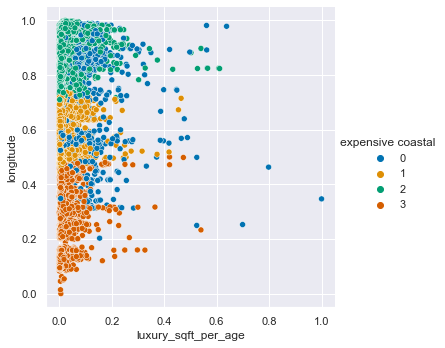

In [37]:
#Visualize my results
sns.relplot(x='luxury_sqft_per_age', y='longitude', hue='expensive coastal',
            palette='colorblind', data=train_scaled)

In [38]:
#Create a new X subset with far from beach, orange and ventura counties,
X7_train = train_scaled[['longitude', 'Orange', 'Ventura','luxury_sqft_per_age','luxury_score']]
X7_validate = validate_scaled[['longitude', 'Orange', 'Ventura','luxury_sqft_per_age','luxury_score']]
X7_test = test_scaled[['longitude', 'Orange', 'Ventura','luxury_sqft_per_age','luxury_score']]

In [39]:
#Fit a KMeans model to my 3 feature dataset
kmeans7 = KMeans(n_clusters=3)

kmeans7.fit(X7_train)

kmeans7.predict(X7_train)

array([1, 2, 1, ..., 1, 0, 1])

In [40]:
#Store my predictions in the dataframe
train_scaled['NotLAluxury'] = kmeans7.predict(X7_train)
validate_scaled['NotLAluxury'] = kmeans7.predict(X7_validate)
test_scaled['NotLAluxury'] = kmeans7.predict(X7_test)

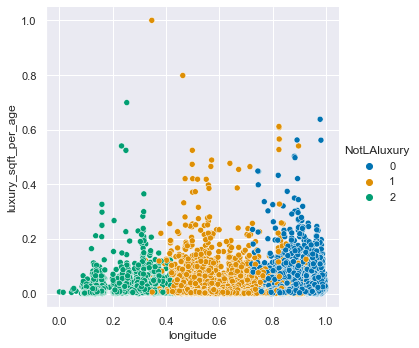

In [41]:
#Visualize my results
sns.relplot(x='longitude', y='luxury_sqft_per_age', hue='NotLAluxury',
            palette='colorblind', data=train_scaled)

In [42]:
#Create a list of inertias for models fit to my 3 features
NotLAluxury = []

for i in range(2, 8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X7_train)
    NotLAluxury.append(kmeans.inertia_)
    
NotLAluxury 

[3150.445962490265,
 710.0177940307892,
 512.606356447305,
 396.882033155145,
 347.09158945201966,
 296.35493117267447]

Text(0.5, 0, 'Number of clusters')

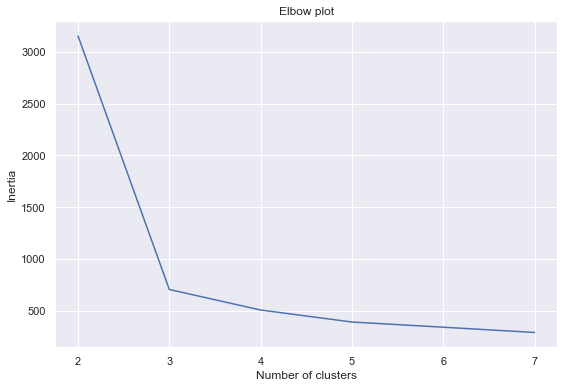

In [43]:
#Plot the inertia over number of clusters
sns.lineplot(x=range(2, 8), y=NotLAluxury)
plt.title('Elbow plot')
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')

In [44]:
#k of 3 for the not in LA and luxury score cluster

In [45]:
#Create a new X subset with 3 features
X3_train = train_scaled[['sqft_room_ratio', 'cost_per_sqft', 'age','home_value']]
X3_validate = validate_scaled[['sqft_room_ratio', 'cost_per_sqft', 'age','home_value']]
X3_test= test_scaled[['sqft_room_ratio', 'cost_per_sqft', 'age','home_value']]

In [46]:
#Fit a KMeans model to my 3 feature dataset
kmeans3 = KMeans(n_clusters=3)

kmeans3.fit(X3_train)

kmeans3.predict(X3_train)

array([1, 1, 0, ..., 2, 1, 0])

In [47]:
#Store my predictions in the dataframe
train_scaled['squarefootage_cost_homevalue'] = kmeans3.predict(X3_train)
validate_scaled['squarefootage_cost_homevalue'] = kmeans3.predict(X3_validate)
test_scaled['squarefootage_cost_homevalue'] = kmeans3.predict(X3_test)

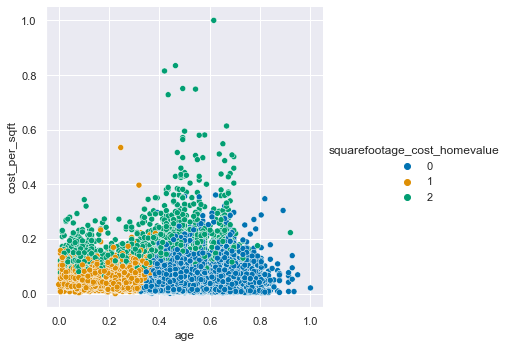

In [48]:
#Visualize my results
sns.relplot(x='age', y='cost_per_sqft', hue='squarefootage_cost_homevalue',
            palette='colorblind', data=train_scaled)

In [49]:
#Create a new X subset with location based features
X4_train = train_scaled[['latitude', 'longitude', 'luxury_sqft_per_age','taxrate']]
X4_validate= validate_scaled[['latitude', 'longitude', 'luxury_sqft_per_age','taxrate']]
X4_test= test_scaled[['latitude', 'longitude', 'luxury_sqft_per_age','taxrate']]

In [50]:
#Fit a KMeans model to my 4 feature dataset
kmeans4 = KMeans(n_clusters=4)

kmeans4.fit(X4_train)

kmeans4.predict(X4_train)

array([3, 1, 0, ..., 0, 2, 0])

In [51]:
#Store my predictions in the dataframe
train_scaled['latlongluxurytax'] = kmeans4.predict(X4_train)
validate_scaled['latlongluxurytax'] = kmeans4.predict(X4_validate)
test_scaled['latlongluxurytax'] = kmeans4.predict(X4_test)

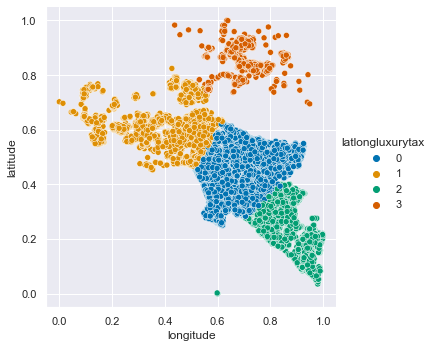

In [52]:
#Visualize my results
sns.relplot(x='longitude', y='latitude', hue='latlongluxurytax',
            palette='colorblind', data=train_scaled)

### Now with additional features at our disposal we can build a regression model for logerror

In [53]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((28792, 31), (12340, 31), (10284, 31))

In [54]:
train_scaled.columns.values.tolist()

['bathrooms',
 'bedrooms',
 'sqft',
 'garagecarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'structuretaxvaluedollarcnt',
 'home_value',
 'landtaxvaluedollarcnt',
 'taxamount',
 'home_value_structure_tax_difference',
 'hvs_pct',
 'taxrate',
 'age',
 'cost_per_sqft',
 'sqft_room_ratio',
 'airconditioning_encoded',
 'luxury_score',
 'luxury_sqft_per_age',
 '2017Q1',
 '2017Q2',
 '2017Q3',
 'LA',
 'Orange',
 'Ventura',
 'expensive coastal',
 'NotLAluxury',
 'squarefootage_cost_homevalue',
 'latlongluxurytax']

In [ ]:
#drop these columns
['garagecarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'hvs_pct',
 'home_value_structure_tax_difference',
 'airconditioning_encoded',
 '2017Q1',
 '2017Q2',
 '2017Q3',
 'LA',
 'Orange',
 'Ventura',
 'expensive coastal',
 'NotLAluxury',
 'squarefootage_cost_homevalue']

In [56]:
train_scaled = train_scaled.drop(columns=['garagecarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'hvs_pct',
 'home_value_structure_tax_difference',
 'airconditioning_encoded',
 '2017Q1',
 '2017Q2',
 '2017Q3',
 'LA',
 'Orange',
 'Ventura',
 'expensive coastal',
 'NotLAluxury',
 'squarefootage_cost_homevalue'])

In [57]:
validate_scaled = validate_scaled.drop(columns=['garagecarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'hvs_pct',
 'home_value_structure_tax_difference',
 'airconditioning_encoded',
 '2017Q1',
 '2017Q2',
 '2017Q3',
 'LA',
 'Orange',
 'Ventura',
 'expensive coastal',
 'NotLAluxury',
 'squarefootage_cost_homevalue'])

In [58]:
test_scaled = test_scaled.drop(columns=['garagecarcnt',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'poolcnt',
 'structuretaxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'hvs_pct',
 'home_value_structure_tax_difference',
 'airconditioning_encoded',
 '2017Q1',
 '2017Q2',
 '2017Q3',
 'LA',
 'Orange',
 'Ventura',
 'expensive coastal',
 'NotLAluxury',
 'squarefootage_cost_homevalue'])

### Dummy encode 'latlongluxurytax' cluster

In [59]:
#dummy latlongluxurytax
dummies = pd.get_dummies(train_scaled['latlongluxurytax'])
train_scaled = pd.concat([train_scaled,dummies],axis=1)

In [60]:
dummies = pd.get_dummies(validate_scaled['latlongluxurytax'])
validate_scaled = pd.concat([validate_scaled,dummies],axis=1)

In [61]:
dummies = pd.get_dummies(test_scaled['latlongluxurytax'])
test_scaled = pd.concat([test_scaled,dummies],axis=1)

#### Note: Further analysis required to provide plain name descriptions for these clusters

In [64]:
# from sklearn.feature_selection import SelectKBest, f_regression

# parameters: f_regression stats test, give me 3 features
f_selector = SelectKBest(f_regression, k=5)

# find the top 8 X's correlated with y
f_selector.fit(train_scaled, y_train.logerror)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = train_scaled.iloc[:,feature_mask].columns.tolist()

In [65]:
f_feature

['bathrooms', 'bedrooms', 'sqft', 'cost_per_sqft', 'luxury_score']

In [66]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=5)

# fit the data using RFE
rfe.fit(train_scaled,y_train.logerror)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = train_scaled.iloc[:,feature_mask].columns.tolist()

In [67]:
rfe_feature

['sqft', 'cost_per_sqft', 'sqft_room_ratio', 'luxury_score', 2]

In [68]:
train_scaled = train_scaled.drop(columns=['latlongluxurytax'])

In [69]:
validate_scaled = validate_scaled.drop(columns=['latlongluxurytax'])

In [70]:
test_scaled = test_scaled.drop(columns=['latlongluxurytax'])

### Modeling

In [71]:
y_train.shape, y_validate.shape, y_test.shape

((28792, 1), (12340, 1), (10284, 1))

### Identify baseline

In [72]:
# 1. compute pred_median
logerror_baseline_median = y_train['logerror'].median()
y_train['logerror_baseline_median'] = logerror_baseline_median
y_validate['logerror_baseline_median'] = logerror_baseline_median
y_test['logerror_baseline_median'] = logerror_baseline_median

# 2. compute pred_mean
logerror_baseline_mean = y_train['logerror'].mean()
y_train['logerror_baseline_mean'] = logerror_baseline_mean
y_validate['logerror_baseline_mean'] = logerror_baseline_mean
y_test['logerror_baseline_mean'] = logerror_baseline_mean
#check to see which is better
y_train.head()

,logerror,logerror_baseline_median,logerror_baseline_mean
758,0.03,0.01,0.02
46573,0.01,0.01,0.02
6569,0.05,0.01,0.02
7138,-0.36,0.01,0.02
16115,-0.05,0.01,0.02


In [73]:
def plot_residuals(target, yhat):
    '''
    plot_residuals will take in a target series and prediction series
    and plot the residuals as a scatterplot.
    '''
    
    residual = target - yhat
    
    plt.scatter(target, residual)
    plt.axhline(y = 0, ls = ':')
    plt.xlabel("target")
    plt.ylabel("residual")
    plt.title('Residual Plot')
    plt.show

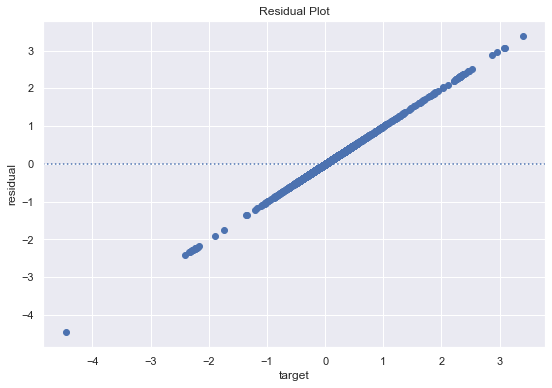

In [74]:
plot_residuals(y_train.logerror, logerror_baseline_median)

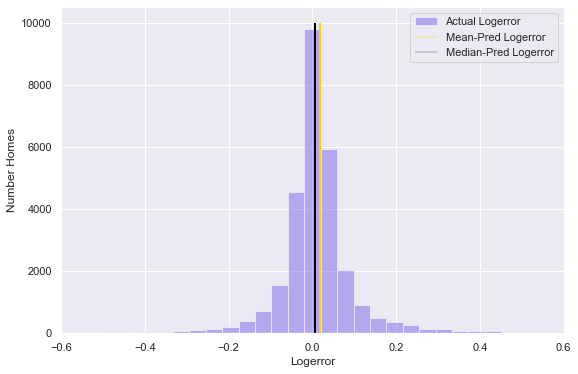

In [75]:
# plot to visualize actual vs predicted.
#median value performs better

plt.hist(y_train.logerror, bins=200, color='mediumslateblue', alpha=.5, label="Actual Logerror")
plt.vlines(y_train.logerror_baseline_mean, 0, 10000, color='gold', alpha=.3, label="Mean-Pred Logerror")
plt.vlines(y_train.logerror_baseline_median, 0,10000, color='black', alpha=.2, label="Median-Pred Logerror")
plt.xlim(-.6,.6)
plt.xlabel("Logerror")
plt.ylabel("Number Homes")
plt.legend()
plt.show()

### median predicted logerror looks good for the baseline

In [76]:
# 3. RMSE of hv_pred_median
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_baseline_median) ** (0.5)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_baseline_median) ** (0.5)

print(f"""
      BASELINE:
      
      RMSE using Median
      Train/In-Sample: {round(rmse_train, 3)}
      Validate/Out-of-Sample: {round(rmse_validate, 3)}
        """)


      BASELINE:
      
      RMSE using Median
      Train/In-Sample: 0.175
      Validate/Out-of-Sample: 0.173
        


### Train / Validate
### Modeling: LinearRegression (OLS)

In [77]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(train_scaled)

# evaluate: rmse
rmse_train_lm = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm)**(0.5)

# predict validate
y_validate['logerror_pred_lm'] = lm.predict(validate_scaled)

# evaluate: rmse
rmse_validate_lm = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm)**(0.5)

### Modeling: LassoLars

In [78]:
# create the model object

lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_lars'] = lars.predict(train_scaled)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.logerror, y_train.logerror_pred_lars)**(0.5)

# predict validate
y_validate['logerror_pred_lars'] = lars.predict(validate_scaled)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lars)**(0.5)

### Modeling: TweedieRegressor (GLM)

In [79]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(train_scaled, y_train.logerror)

# predict train
y_train['logerror_pred_glm'] = glm.predict(train_scaled)

# evaluate: rmse
rmse_train_glm = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(0.5)

# predict validate
y_validate['logerror_pred_glm'] = glm.predict(validate_scaled)

# evaluate: rmse
rmse_validate_glm = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_glm)**(0.5)

### Modeling: PolynomialFeatures

In [80]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
train_scaled_degree2 = pf.fit_transform(train_scaled)

# transform X_validate_scaled & X_test_scaled
validate_scaled_degree2 = pf.transform(validate_scaled)
# test_scaled_degree2 = pf.transform(test_scaled_degree2)

In [81]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(train_scaled_degree2, y_train.logerror)

# predict train
y_train['logerror_pred_lm2'] = lm2.predict(train_scaled_degree2)

# evaluate: rmse
rmse_train_lm2 = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm2)**(0.5)

# predict validate
y_validate['logerror_pred_lm2'] = lm2.predict(validate_scaled_degree2)

# evaluate: rmse
rmse_validate_lm2 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm2)**(0.5)

In [82]:
print(f"""
              BASELINE:
              
              RMSE using Median
              Train/In-Sample: {round(rmse_train, 3)}
              Validate/Out-of-Sample: {round(rmse_validate, 3)}
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: {round(rmse_train_lm, 3)}
                Validation/Out-of-Sample: {round(rmse_validate_lm, 3)}

                RMSE for LassoLars
                
                Training/In-Sample: {round(rmse_train_lars, 3)}
                Validation/Out-of-Sample: {round(rmse_validate_lars, 3)}
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: {round(rmse_train_glm, 3)}
                Validation/Out-of-Sample: {round(rmse_validate_glm, 3)}
                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: {round(rmse_train_lm2, 3)}
    Validation/Out-of-Sample: {round(rmse_validate_lm2, 3)}
""")


              BASELINE:
              
              RMSE using Median
              Train/In-Sample: 0.175
              Validate/Out-of-Sample: 0.173
              
                RMSE for OLS using LinearRegression
                
                Training/In-Sample: 0.175
                Validation/Out-of-Sample: 0.173

                RMSE for LassoLars
                
                Training/In-Sample: 0.175
                Validation/Out-of-Sample: 0.173
    
                RMSE for TweedieRegressor (GLM)
                power=1, alpha=0
                
                Training/In-Sample: 0.175
                Validation/Out-of-Sample: 0.173
                
    
    RMSE for Polynomial Regressor
    degrees=2
    
    Training/In-Sample: 0.174
    Validation/Out-of-Sample: 0.174



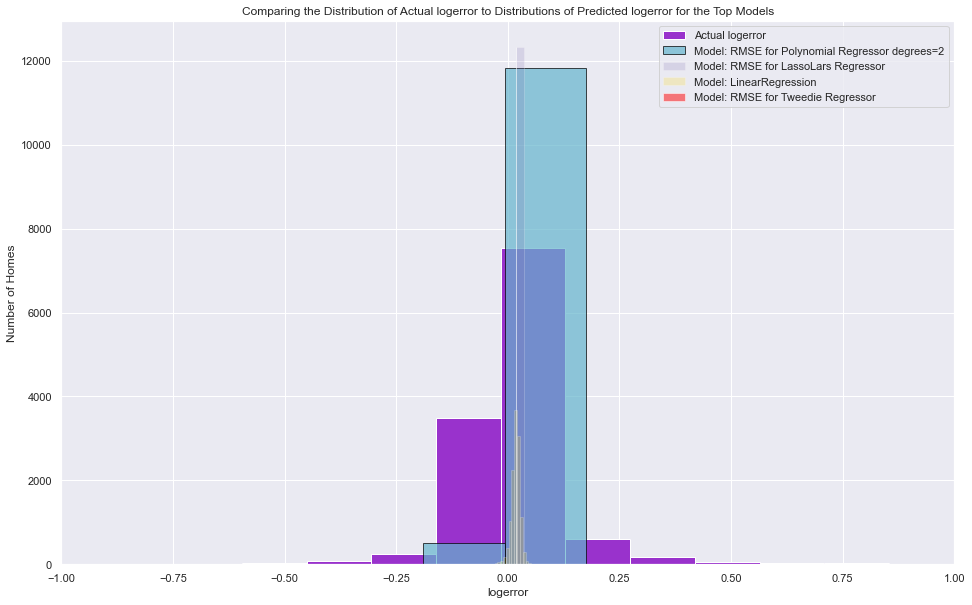

In [85]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,10))
plt.hist(y_validate.logerror, color='darkorchid', alpha=1, bins=50, label="Actual logerror")
plt.hist(y_validate.logerror_pred_lm2, color='c', alpha=.7, bins=10, label="Model: RMSE for Polynomial Regressor degrees=2", ec='black')
# plt.hist(y_validate.logerror_pred_lm3, color='chartreuse', alpha=.2, bins=50, label="Model: RMSE for Polynomial Regressor degrees=3")
plt.hist(y_validate.logerror_pred_lars, color='m', alpha=.2, bins=50,label="Model: RMSE for LassoLars Regressor ")
plt.hist(y_validate.logerror_pred_lm, color='gold', alpha=.2, bins=50,label="Model: LinearRegression")
plt.hist(y_validate.logerror_pred_lars, color='red', alpha=.5, bins=510, label="Model: RMSE for Tweedie Regressor")

plt.xlim(-1, 1)
plt.xlabel("logerror")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual logerror to Distributions of Predicted logerror for the Top Models")
plt.legend()
plt.show()

### Looks like my best model is the Tweedie regressor

perform test model on test set

In [86]:
# predict train
y_test['logerror_pred_glm'] = glm.predict(test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm)**(0.5)

print(f"""
    RMSE for Tweedie Regressor 
    
    Test/Out-of-Sample Performance: {round(rmse_test, 3)}
""")


    RMSE for Tweedie Regressor 
    
    Test/Out-of-Sample Performance: 0.175



### Summary
    -Following the evaluation of the different models using my selected features, I found that the best performing model was the tweedie Regressor it performed best vs the baseline rmse with a score of 0.175. Looks like it performs best when around the median logerror.

    -Next Steps: I would like to look at trimming down the number of features and utilizing only a select few that I felt were effective during feature enginneering. Potentially use the cluster feature and a few others in order to improve model performance.
    -Further analysis would allow for application of different clusters created and applied to the model. 'coastal luxury' and 'notlaluxury' I would like to explore